## Import the Package

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an ImageImport the Package

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


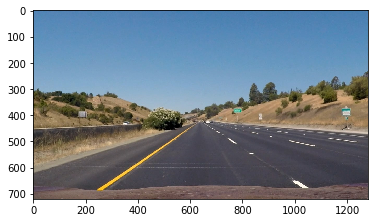

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## First, I'll compute the camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
#cv2.destroyAllWindows()

In [ ]:
objpoints

In [ ]:
imgpoints

## I obatined the objpoints and imgpoints for calibration 

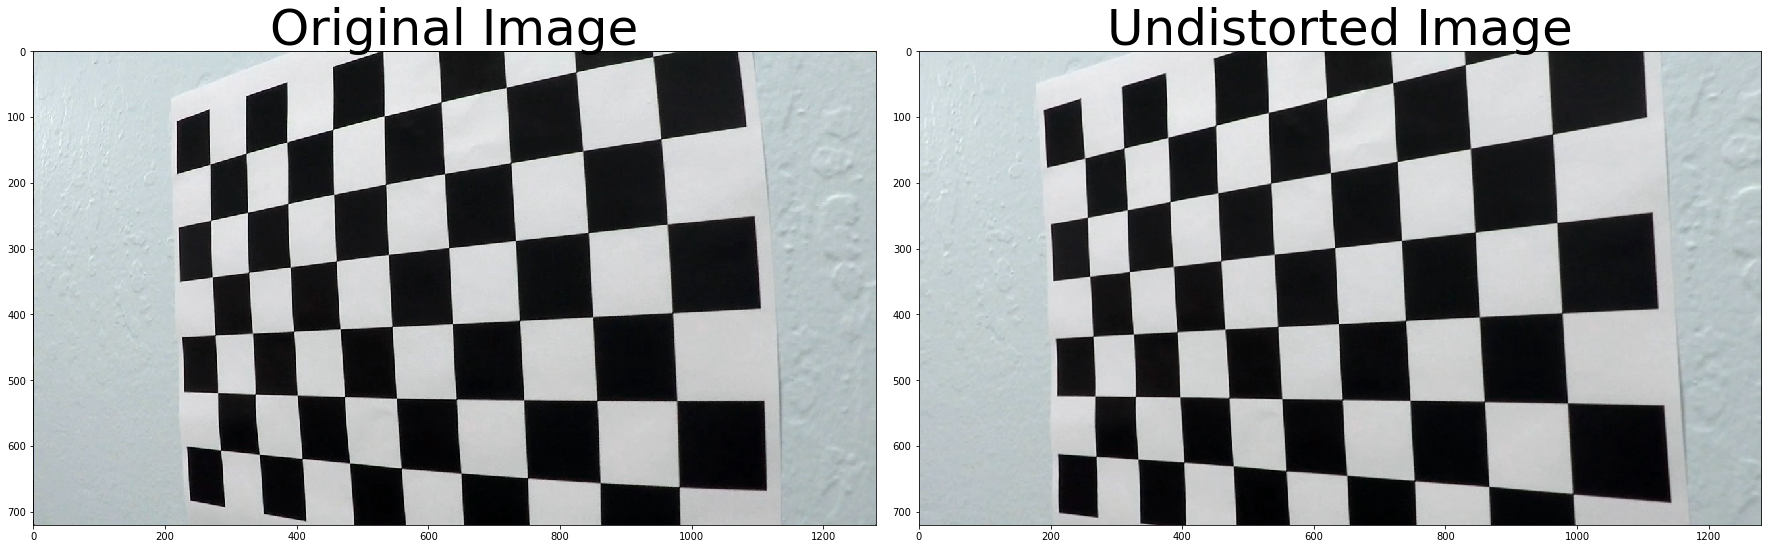

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread('camera_cal/calibration4.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/undistort_output.png") # To save figure

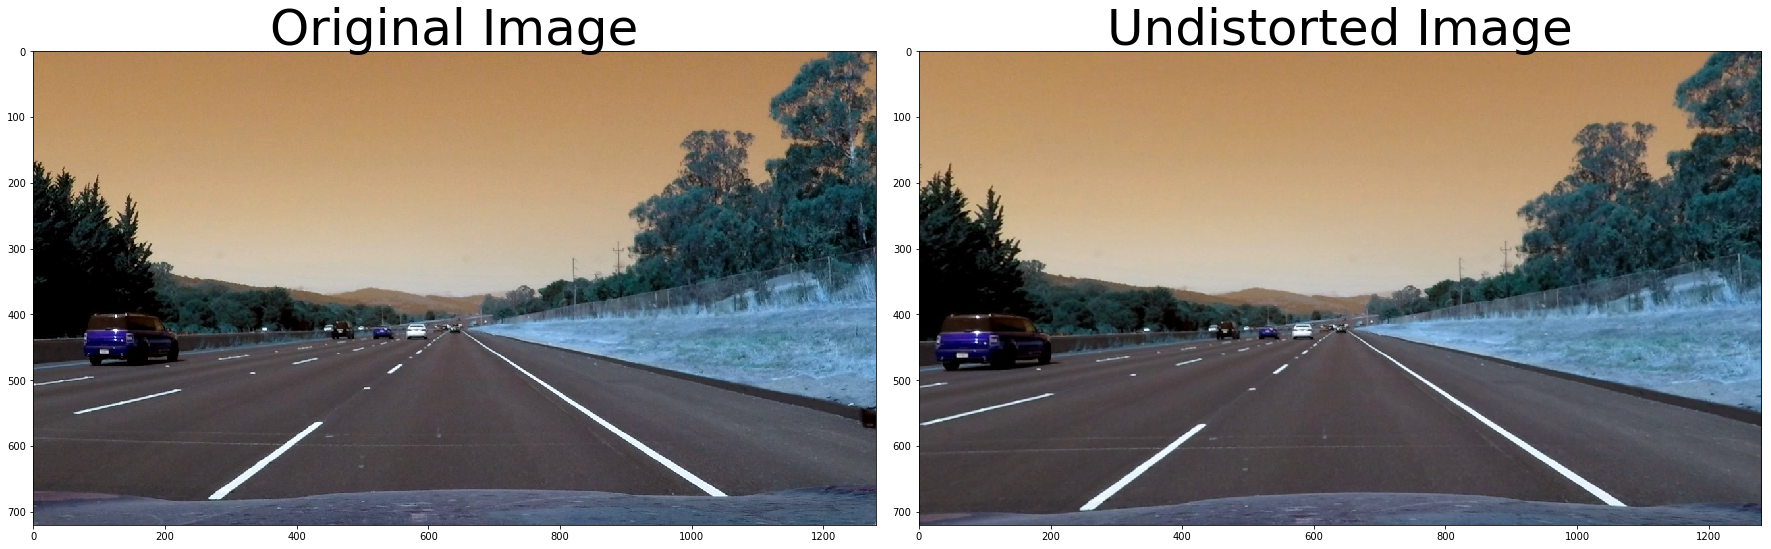

In [5]:
img = cv2.imread('test_images/straight_lines2.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/undistort_test1.png") # To save figure

## Use Color Transforms, Gradients, etc., to create a Thresholded Binary Image.

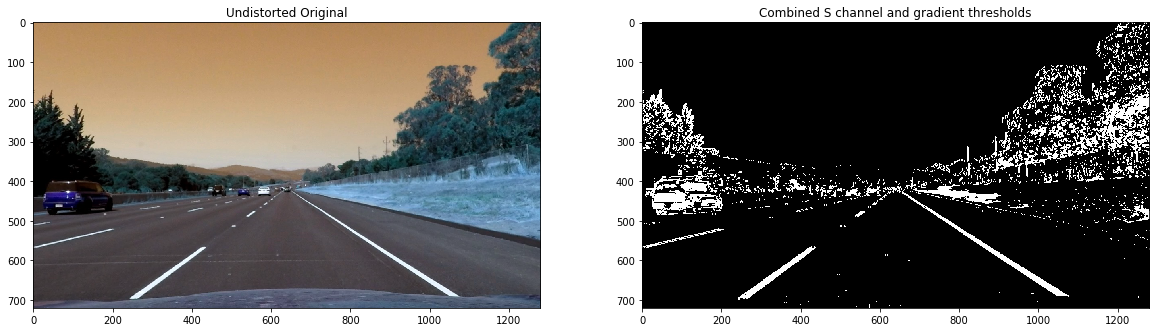

In [6]:
# Convert to HLS color space and separate the S channel
# Note: the input "img" is the undistorted image

def advance_combo(img, thresh=(20, 200), s_thresh=(120,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

# Plotting thresholded images
combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Original')
ax1.imshow(undistorted)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combo, cmap='gray')
plt.savefig("output_images/binary_combo_final.png") 

## Apply a perspective transform to rectify binary image ("birds-eye view")


### Find a trapezoidal shape 

In [7]:
img.shape[:] 

(720, 1280, 3)

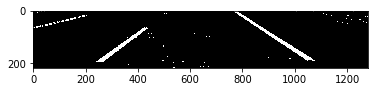

In [8]:
plt.imshow(combo[500:720-1,:],cmap='gray')

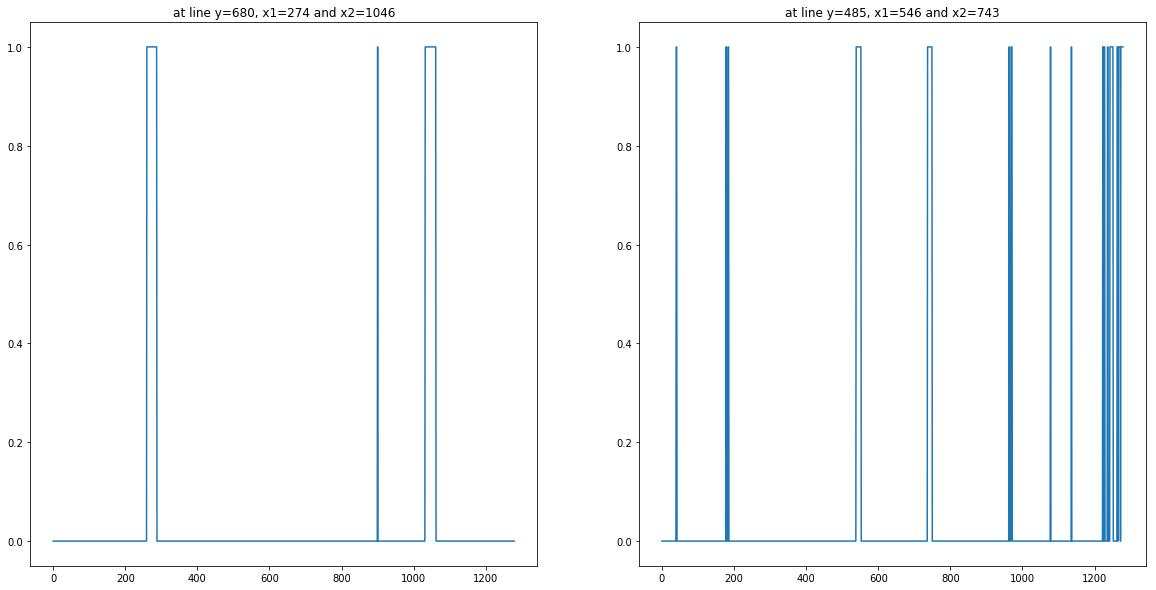

In [9]:
data1=combo[680,:]
data2=combo[485,:]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('at line y=680, x1=274 and x2=1046')
ax1.plot(np.arange(len(data1)),data1)

ax2.set_title('at line y=485, x1=546 and x2=743')
ax2.plot(np.arange(len(data2)),data2)

plt.savefig("output_images/line-plot.png") 

In [ ]:
(274,680)  (1046,680)

In [ ]:
data=combined_binary[485,:]
plt.plot(np.arange(len(data)),data)

In [ ]:
(546,485) (743,485)

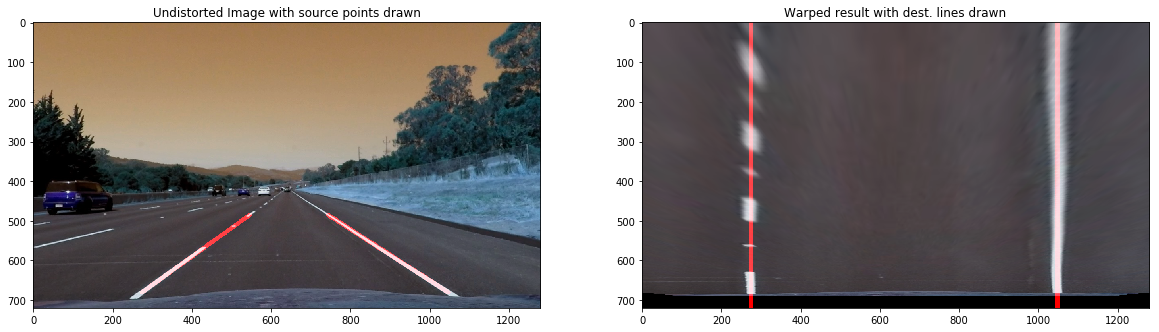

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

image = undistorted            
line_image1 = np.copy(image)*0 # creating a blank to draw lines on
lines1 = [[[274,680,546,485],[1046,680,743,485]]]
draw_lines(line_image1, lines1, color=[255, 0, 0], thickness=10)
lines_edges1 = weighted_img(line_image1, image, 0.9, 1, 0) 
#plt.imshow(lines_edges1, cmap='gray')

src = np.float32([[274,680],[1046,680],[546,485],[743,485]])
dst = np.float32([[274,680],[1046,680],[274,485],[1046,485]])
M = cv2.getPerspectiveTransform(src, dst)
img_size = (undistorted.shape[1], undistorted.shape[0])
warped = cv2.warpPerspective(undistorted, M, img_size)

line_image2 = np.copy(undistorted)*0 # creating a blank to draw lines on
lines2 = [[[274,0,274,719],[1046,0,1046,719]]]
draw_lines(line_image2, lines2, color=[255, 0, 0], thickness=10)
lines_edges2 = weighted_img(line_image2, warped, 0.9, 1, 0) 
#plt.imshow(lines_edges, cmap='gray')

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image with source points drawn')
ax1.imshow(lines_edges1)

ax2.set_title('Warped result with dest. lines drawn')
ax2.imshow(lines_edges2)
plt.savefig("output_images/warped_straight_lines.jpg") 

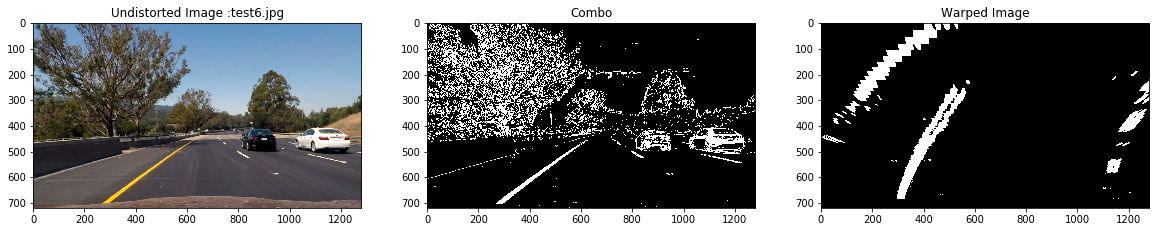

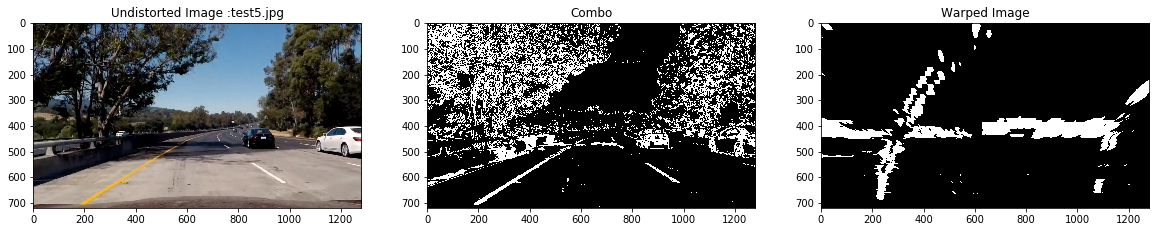

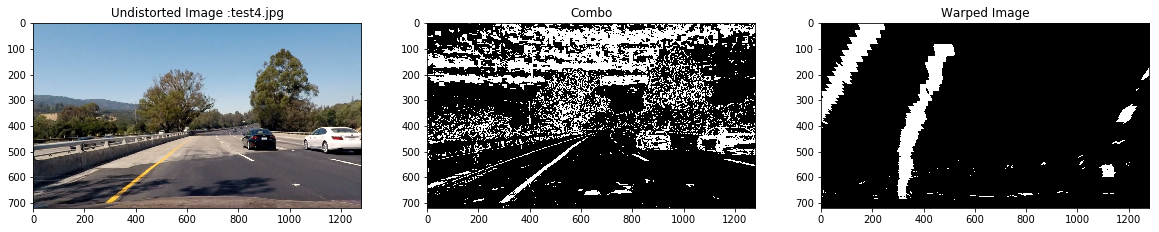

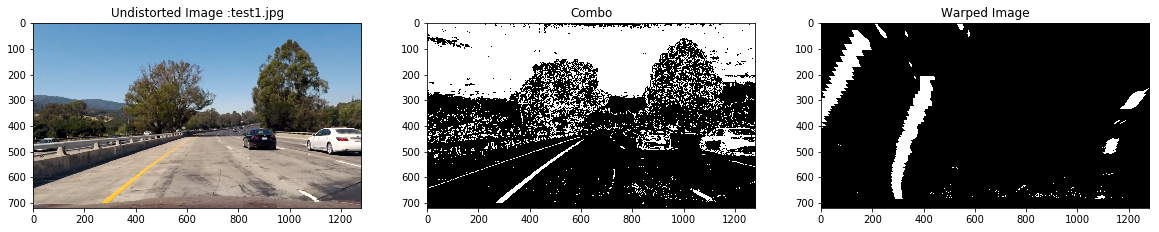

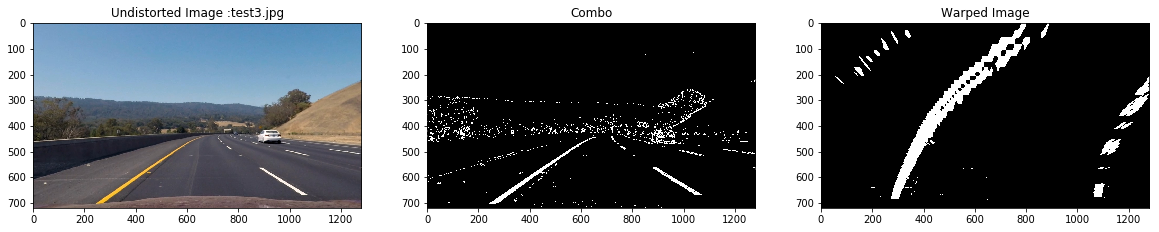

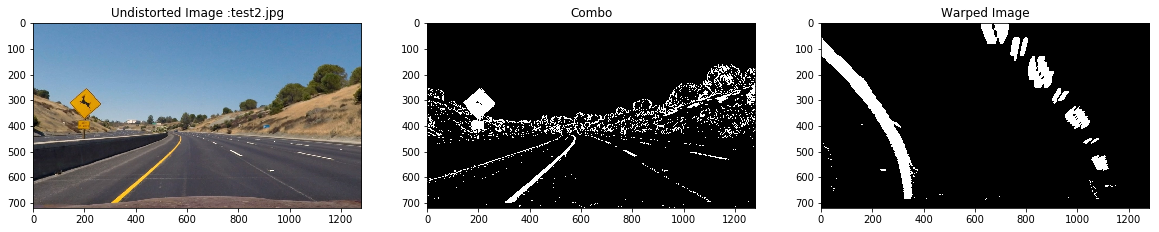

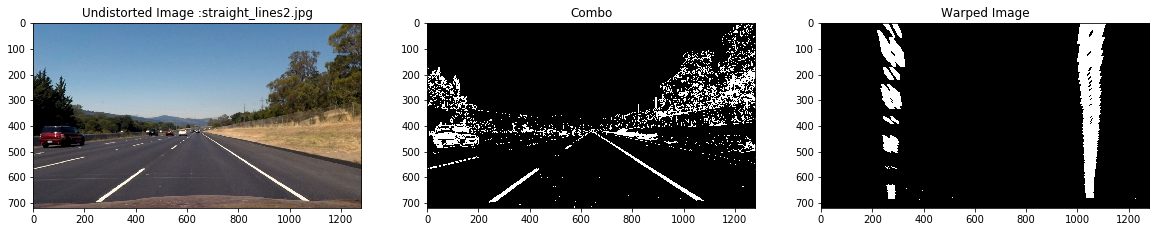

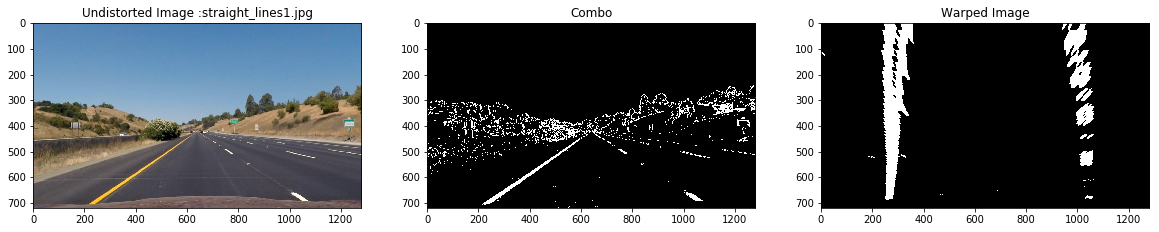

In [36]:
import os
test_img_list= os.listdir("test_images/")
def plot(img, undistorted, combo, warped, img_name):
    #plt.imshow(img)
    #plt.show()
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.set_title('Undistorted Image :'+ img_name)
    ax1.imshow(undistorted)
    ax2.set_title('Combo')
    ax2.imshow(combo,cmap='gray')
    ax3.set_title('Warped Image')
    ax3.imshow(warped,cmap='gray')    
    #plt.savefig("output_images/warped_straight_lines.jpg") 
    
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    plot(img, undistorted, combo, warped, img_name)

## Detect lane pixels and fit to find the lane boundary.

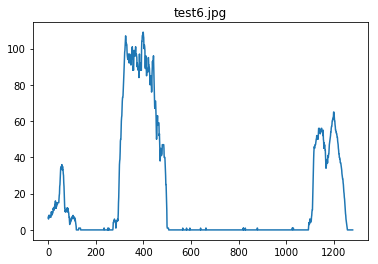

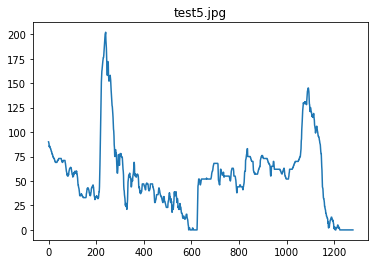

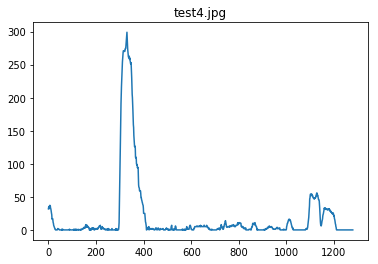

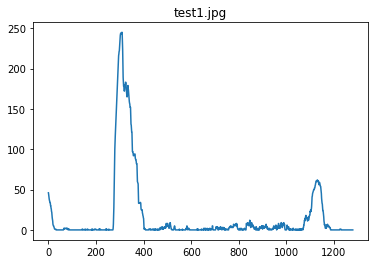

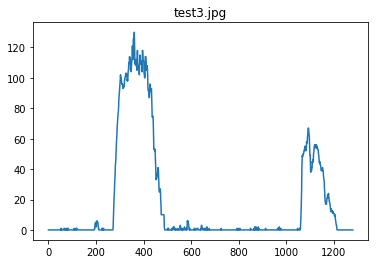

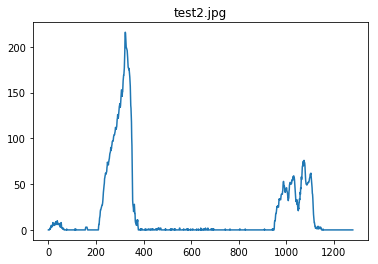

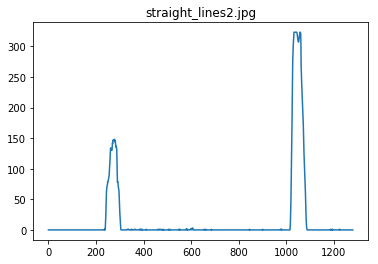

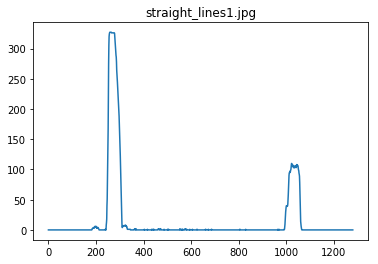

In [48]:
#img = mpimg.imread('warped-example.jpg')/255
#img = lines_edges2
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# Create histogram of image binary activations
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Visualize the resulting histogram
    plt.plot(histogram) 
    plt.title(img_name)
    plt.show()

### find_lane_pixels and fit_polynomial

In [54]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
#binary_warped = mpimg.imread('warped-example.jpg')
#binary_warped = lines_edges

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

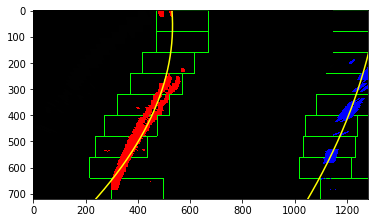

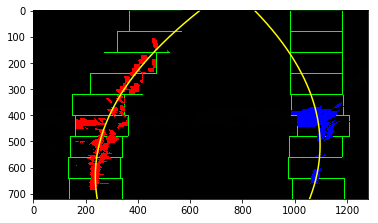

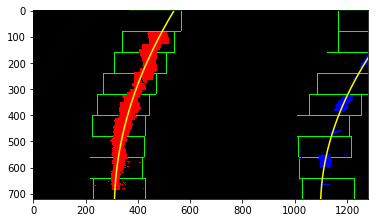

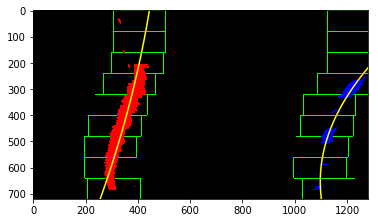

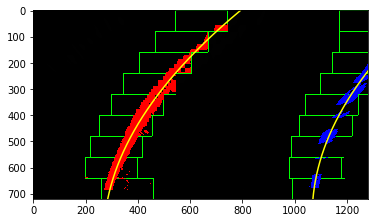

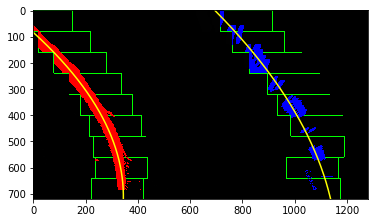

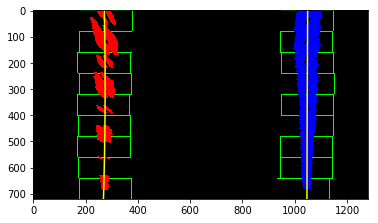

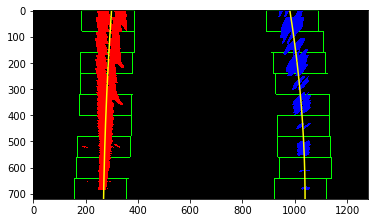

In [55]:
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    out_img = fit_polynomial(warped)
    plt.imshow(out_img)
    plt.show()

### Finding the Lines- Search from Prior

In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

## Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

## Warp the detected lane boundaries back onto the original image.


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Pipeline

In [ ]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test on Videos